# Stroke prediction using Logistic Regression

### Data cleaning 

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('stroke-dataset.csv')
backup_dataset = dataset.copy()
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [84]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [85]:
dataset['work_type'].value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [86]:
dataset['Residence_type'].value_counts()

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

In [87]:
dataset['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [88]:
dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000



Stroke Distribution:
 stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


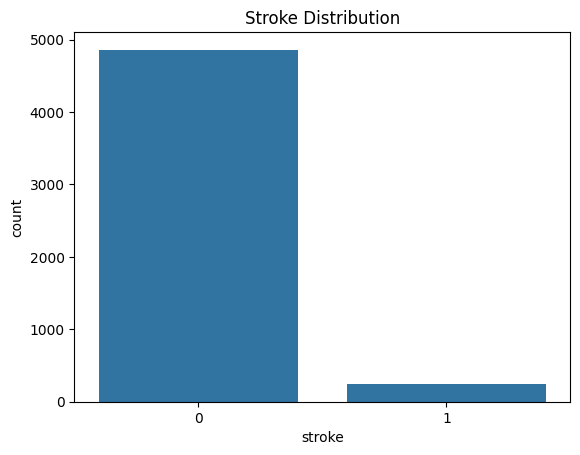

In [89]:
# Target variable distribution
print("\nStroke Distribution:\n", dataset['stroke'].value_counts(normalize=True))
sns.countplot(data=dataset, x='stroke')
plt.title("Stroke Distribution")
plt.show()

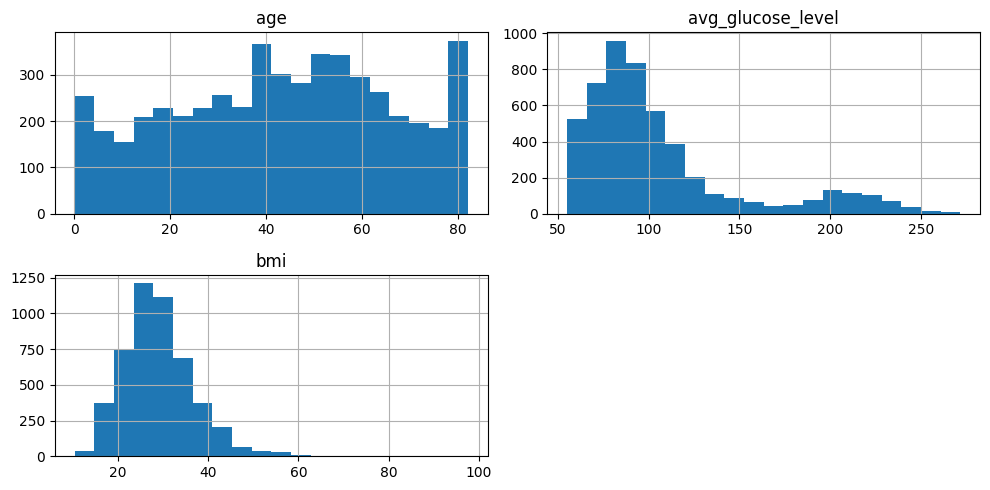

In [90]:
# Numeric columns distribution
numeric_cols = ['age', 'avg_glucose_level', 'bmi']
dataset[numeric_cols].hist(bins=20, figsize=(10, 5))
plt.tight_layout()
plt.show()

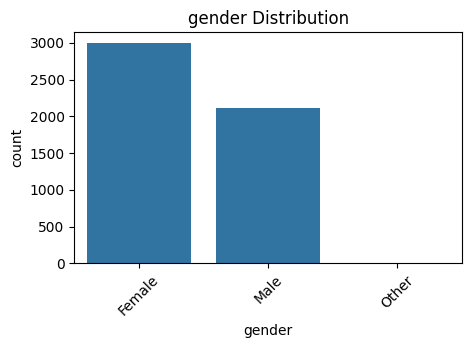

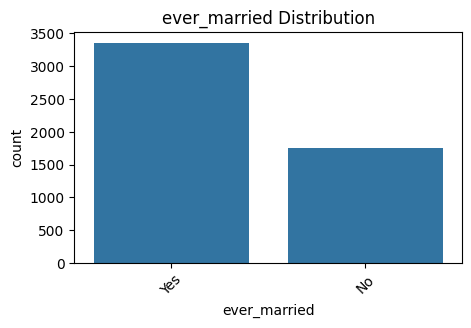

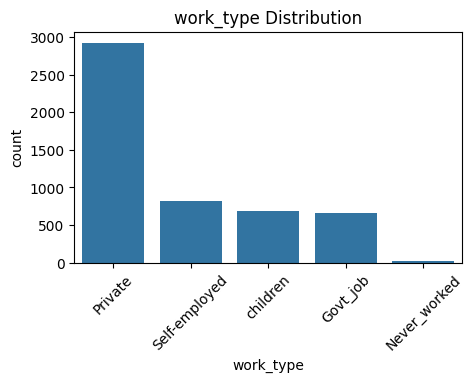

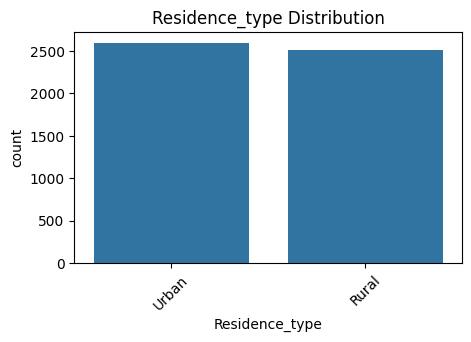

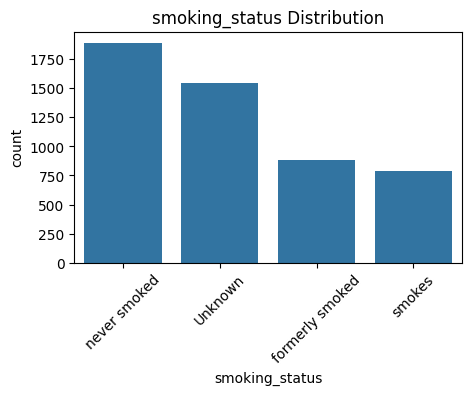

In [91]:

# Categorical columns distribution
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for col in categorical_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(data=dataset, x=col, order=dataset[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=45)
    plt.show()

In [92]:
# Missing value handling fill BMI with median
dataset['bmi'] = dataset['bmi'].fillna(dataset['bmi'].median())

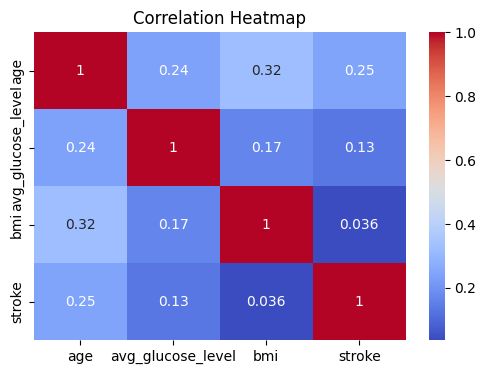

In [93]:
# Correlation heatmap (numeric only)
plt.figure(figsize=(6,4))
sns.heatmap(dataset[numeric_cols + ['stroke']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [94]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


#### preprocessing

In [95]:

dataset.drop('id', axis=1, inplace=True)

# Map binary categorical variables to 0/1
binary_mappings = {
    'ever_married': {'No': 0, 'Yes': 1},
    'Residence_type': {'Rural': 0, 'Urban': 1},
    'gender': {'Male': 0, 'Female': 1, 'Other': 2}  # 'Other' kept as 2 just in case
}
dataset.replace(binary_mappings, inplace=True)

# One-hot encode multi-category variables
dataset = pd.get_dummies(dataset, columns=['work_type', 'smoking_status'], drop_first=True)

# Convert only one-hot columns to int
one_hot_cols = [col for col in dataset.columns if ('work_type_' in col) or ('smoking_status_' in col)]
dataset[one_hot_cols] = dataset[one_hot_cols].astype(int)


C:\Users\ghost\AppData\Local\Temp\ipykernel_5916\1747262010.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.replace(binary_mappings, inplace=True)


In [96]:
backup_dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [97]:
dataset.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,1,0,0
1,1,61.0,0,0,1,0,202.21,28.1,1,0,0,1,0,0,1,0
2,0,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,0,1,0
3,1,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0,0,0,1
4,1,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,1,0


#### data split and model training

In [98]:
X = dataset.drop('stroke', axis=1)
y = dataset['stroke']

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [100]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [101]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression with balanced class weights
logReg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logReg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [104]:
y_pred = logReg.predict(X_test)
y_pred_proba = logReg.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

[[739 229]
 [ 16  38]]
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       968
           1       0.14      0.70      0.24        54

    accuracy                           0.76      1022
   macro avg       0.56      0.73      0.55      1022
weighted avg       0.93      0.76      0.82      1022

ROC-AUC: 0.811524334251607


In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Get predicted probabilities for class 1
y_proba = logReg.predict_proba(X_test)[:, 1]
# Try different thresholds
thresholds = np.arange(0, 1.05, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    precision = precision_score(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    results.append((t, precision, recall, f1))

# Show results
print("Threshold | Precision | Recall | F1")
for t, p, r, f in results:
    print(f"{t:.2f}      | {p:.2f}      | {r:.2f}   | {f:.2f}")

Threshold | Precision | Recall | F1
0.00      | 0.05      | 1.00   | 0.10
0.05      | 0.07      | 0.96   | 0.12
0.10      | 0.08      | 0.96   | 0.15
0.15      | 0.09      | 0.96   | 0.16
0.20      | 0.09      | 0.93   | 0.17
0.25      | 0.10      | 0.91   | 0.19
0.30      | 0.11      | 0.85   | 0.19
0.35      | 0.11      | 0.81   | 0.20
0.40      | 0.12      | 0.80   | 0.21
0.45      | 0.14      | 0.74   | 0.23
0.50      | 0.14      | 0.70   | 0.24
0.55      | 0.16      | 0.69   | 0.26
0.60      | 0.17      | 0.67   | 0.27
0.65      | 0.19      | 0.61   | 0.28
0.70      | 0.19      | 0.54   | 0.28
0.75      | 0.21      | 0.48   | 0.29
0.80      | 0.21      | 0.37   | 0.26
0.85      | 0.23      | 0.22   | 0.22
0.90      | 0.33      | 0.09   | 0.14
0.95      | 1.00      | 0.02   | 0.04
1.00      | 0.00      | 0.00   | 0.00


g:\prog\python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
